# Задание 10 - ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА
_Орешкин А.В._  

---
## 0. ПОСТАНОВКА ПРОБЛЕМЫ

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

2. Ответить на ключевые вопросы HR-агентства:
* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
3. Найти в данных другие интересные закономерности.

---
# **1. ЗАГРУЗКА И ОБРАБОТКА ДАННЫХ**

## 1.1. Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv', index_col=0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


**НАИМЕНОВАНИЕ СТОЛБЦА	ОПИСАНИЕ**

work_year	Год, в котором была выплачена зарплата.

experience_level	Опыт работы на этой должности в течение года со следующими возможными значениями:
- EN — Entry-level/Junior;
- MI — Mid-level/Intermediate;
- SE — Senior-level/Expert;
- EX — Executive-level/Director.

employment_type	Тип трудоустройства для этой роли:
- PT — неполный рабочий день;
- FT — полный рабочий день;
- CT — контракт;
- FL — фриланс.

job_title	Роль, в которой соискатель работал в течение года.

salary	Общая выплаченная валовая сумма заработной платы.

salary_currency	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.

salary_in_usd	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).

employee_residence	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.

remote_ratio	Общий объём работы, выполняемой удалённо. Возможные значения:
- 0 — удалённой работы нет (менее 20 %);
- 50 — частично удалённая работа;
- 100 — полностью удалённая работа (более 80 %).

company_location	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.

company_size	Среднее количество людей, работавших в компании в течение года:
- S — менее 50 сотрудников (небольшая компания);
- M — от 50 до 250 сотрудников (средняя компания);
- L — более 250 сотрудников (крупная компания).


## 1.2. Очистка данных

### 1.2.1. Неинформативные признаки

Получение списка неинформативных признаков, у которых доля от общих данных, которую занимает каждое уникальное значение в признаке, более 95%

In [3]:
def get_nunique_ratio(data):
  #список неинформативных признаков
  low_information_cols = [] 

  #цикл по всем столбцам
  for col in data.columns:
      #наибольшая относительная частота в признаке
      top_freq = data[col].value_counts(normalize=True).max()
      #доля уникальных значений от размера признака
      nunique_ratio = data[col].nunique() / data[col].count()
      # сравниваем наибольшую частоту с порогом
      if top_freq > 0.95:
          low_information_cols.append(col)
          print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
      # сравниваем долю уникальных значений с порогом
      if nunique_ratio > 0.95:
          low_information_cols.append(col)
          print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

In [4]:
get_nunique_ratio(data)

employment_type: 96.87% одинаковых значений


In [5]:
#Удаляем неинформативный признак 
data = data.drop(['employment_type'], axis=1)

Среди признаков, которые можем считать неинформативные, я бы выделил следующие:
- salary - Не очень понятно, зачем нам общая выплаченная валовая сумма зп, с учетом того, что непонятно в какой валюте и не понятно за какой срок.
- salary_currency - т.к. у нас уже есть приведение месячной зп к долларам США, то данный признак не нужен.
- employee_residence - данные о стране проживания нам не помогут ответить на поставленные вопросы.
- company_location - данные о нахождении главного офиса компании, также нам не помогут ответить на поставленные вопросы.

In [6]:
# Удаляем неинформативные признаки
data = data.drop(['salary', 'salary_currency', 'employee_residence', 'company_location'], axis=1)

Удаляем записи, где роль не равна Data Scientist и Data Engineer

In [7]:
mask1 = data['job_title'] == 'Data Scientist'
mask2 = data['job_title'] == 'Data Engineer'
data = data[mask1 | mask2]

### 1.2.2. Пропущенные значения

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 0 to 603
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   work_year         275 non-null    int64 
 1   experience_level  275 non-null    object
 2   job_title         275 non-null    object
 3   salary_in_usd     275 non-null    int64 
 4   remote_ratio      275 non-null    int64 
 5   company_size      275 non-null    object
dtypes: int64(3), object(3)
memory usage: 15.0+ KB


В датасете 607 записей (без пропущенных значений).

### 1.2.3. Преобразование данных

Пока не определил признаки, которые надо преобразовать

### 1.2.4. Выбросы (иследование данных по каждому числовому признаку)

**Признак work_year**

In [9]:
data['work_year'].unique()

array([2020, 2021, 2022], dtype=int64)

Признак work_year категориальный порядковый.

**Признак salary_in_usd**

In [10]:
data['salary_in_usd'].describe()

count       275.000000
mean     110365.672727
std       61018.226536
min        2859.000000
25%       65438.000000
50%      104702.000000
75%      150000.000000
max      412000.000000
Name: salary_in_usd, dtype: float64

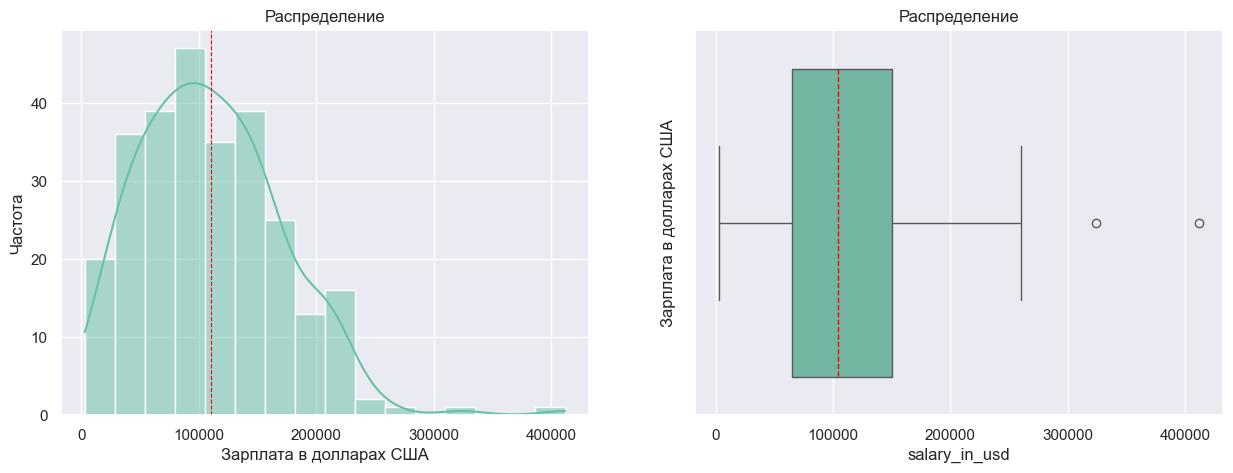

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Распределение')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Зарплата в долларах США')
axes[1].set_title('Распределение')

plt.show()

In [12]:
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = (data[feature])
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [13]:
# Определяем выбросы

outliers, cleaned = outliers_z_score_mod(
    data = data, feature = 'salary_in_usd', log_scale=True, left=3, right=3)
print(f'Число выбросов по методу Z-ОТКЛОНЕНИЙ: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Z-ОТКЛОНЕНИЙ: 5
Результирующее число записей: 270


In [14]:
# Удаляем выбросы
data = cleaned

In [15]:
outliers

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_size
127,2021,MI,Data Scientist,9466,0,S
176,2021,MI,Data Scientist,2859,0,S
179,2021,MI,Data Scientist,5679,100,S
185,2021,MI,Data Engineer,4000,100,M
238,2021,EN,Data Scientist,4000,0,M


Посмотрим логорифмированную диаграмму распределения после удаления выбросов

Text(0.5, 1.0, 'Распределение')

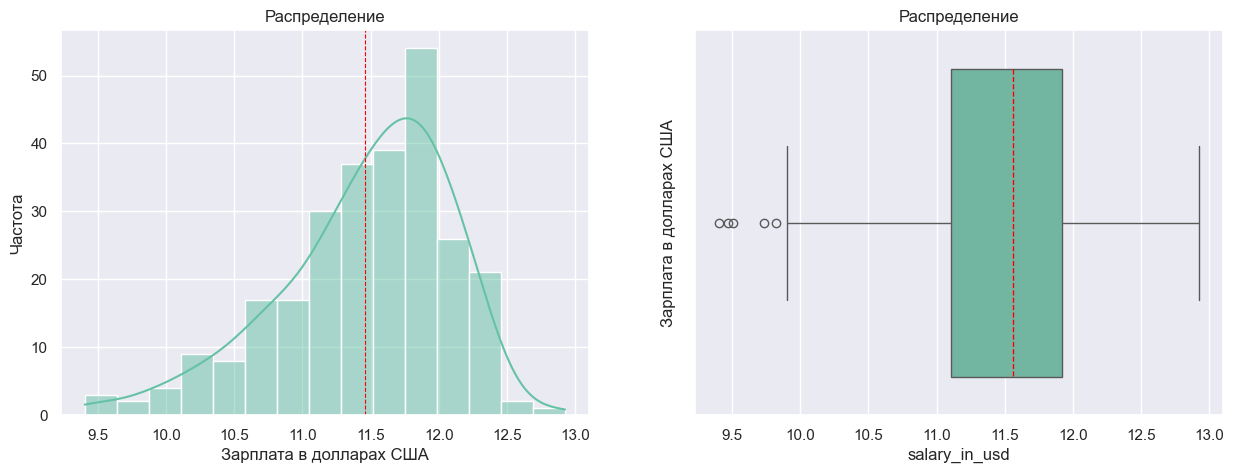

In [16]:
x = np.log(data['salary_in_usd'])
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(x, kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Распределение')
axes[0].axvline(x.mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(x, ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Зарплата в долларах США')
axes[1].set_title('Распределение')

**Признак remote_ratio**

In [17]:
data['remote_ratio'].unique()

array([  0,  50, 100], dtype=int64)

Признак work_year категориальный порядковый.

### 1.2.5. Дубликаты

In [18]:
# Поиск дублирующих записей
duplicates = data[data.duplicated()]
duplicates.shape[0]

28

In [19]:
# Удаление дублирующих записей
data.drop_duplicates(inplace=True)

### 1.2.6. Корректность типов данных

**Признак work_year**

Т.к. в данном признаке мы имеем только цифровое четырехзначное значение года, то достаточно будет типа int16

In [20]:
data['work_year'] = data['work_year'].astype('Int16')

**Признак remote_ratio**

Т.к. в данном признаке мы имеем только знаяения до 100, то достаточно будет типа int8

In [21]:
data['remote_ratio'] = data['remote_ratio'].astype('Int8')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 0 to 603
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   work_year         242 non-null    Int16 
 1   experience_level  242 non-null    object
 2   job_title         242 non-null    object
 3   salary_in_usd     242 non-null    int64 
 4   remote_ratio      242 non-null    Int8  
 5   company_size      242 non-null    object
dtypes: Int16(1), Int8(1), int64(1), object(3)
memory usage: 10.6+ KB


## 1.3. Классификация признаков

- work_year - категориальный, порядковый
- experience_level - категориальный
- job_title - категориальный
- salary_in_usd - числовой
- remote_ratio - категориальный, порядковый
- company_size - категориальный

## 1.4. Определение статистических характиристик признаков

**Признак salary_in_usd**
Оцениваем выборку данных и определяем, насколько вероятно, что данные были получены из нормального распределения (Тест Шапиро — Уилка)

In [23]:
data['salary_in_usd'].describe()

count       242.000000
mean     109120.636364
std       60352.875553
min       12103.000000
25%       65003.250000
50%      101185.000000
75%      146750.000000
max      412000.000000
Name: salary_in_usd, dtype: float64

In [24]:
# задаём уровень значимости
alpha = 0.05 


# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data['salary_in_usd'])

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


 ---
# **2. Разведывательный анализ данных**

## 2.1. Визуальный анализ данных

**Признак salary_in_usd**

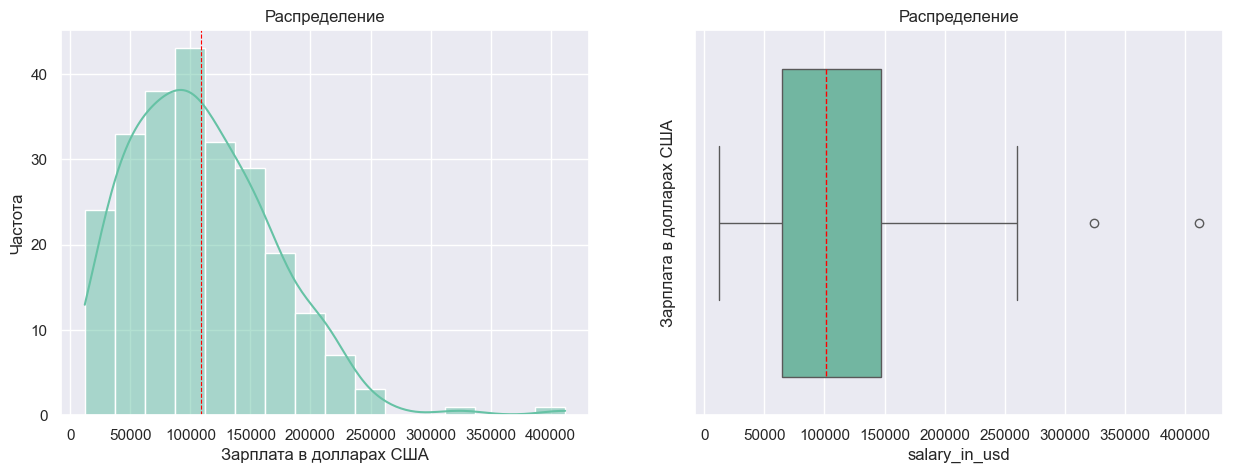

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Распределение')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Зарплата в долларах США')
axes[1].set_title('Распределение')

plt.show()

Также, как и ранее мы определили тестом Шапиро — Уилка, распределение не нормальное. медиана и срежнее значение не совпадают.

**Зависимость ЗП Data Scientist от года**

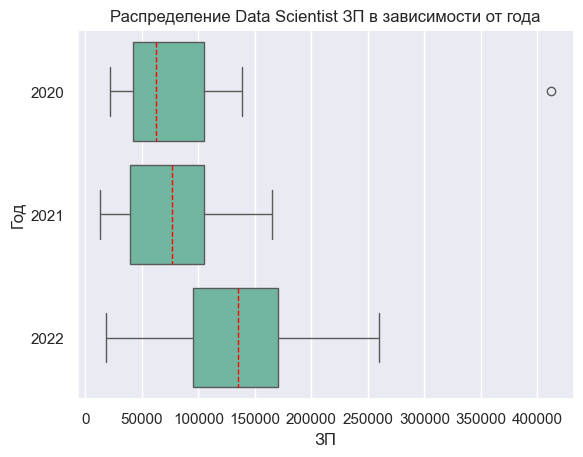

In [26]:
mask = data['job_title'] == 'Data Scientist'
filtered = data[mask]
ax = sns.boxplot(filtered, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='ЗП', ylabel='Год')
plt.title('Распределение Data Scientist ЗП в зависимости от года')
plt.show()

In [27]:
data_agg = filtered.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение ЗП в зависимости от года')
data_agg

Распределение ЗП в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,40.0,76687.25,42942.71,12901.0,39484.75,76729.0,105018.25,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


**ВЫВОД**: На диаграмме видим, что уровень ЗП растет с каждым годом. Это видно как по самому распределению, так и по медиане.

**Соотношение ЗП Data Scientist и Data Engineer в 2022 году**

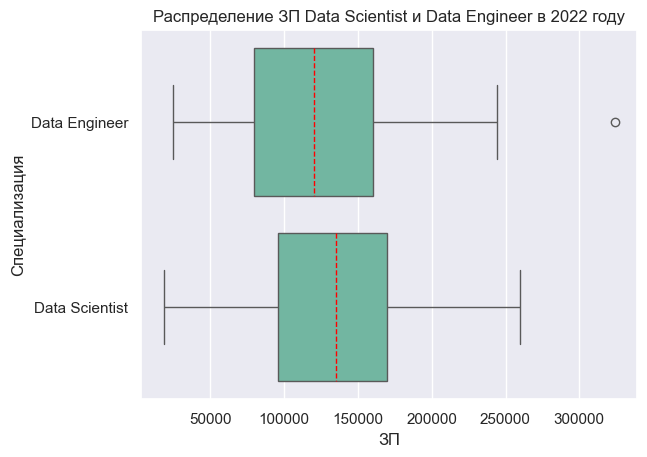

In [28]:
mask = data['work_year'] == 2022
filtered = data[mask]

filtered = data[mask]
ax = sns.boxplot(filtered, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='ЗП', ylabel='Специализация')
plt.title('Распределение ЗП Data Scientist и Data Engineer в 2022 году')
plt.show()

In [29]:
data_agg = filtered.groupby('job_title')['salary_in_usd'].describe().round(2)
print('Распределение ЗП Data Scientist и Data Engineer в 2022 году')
data_agg

Распределение ЗП Data Scientist и Data Engineer в 2022 году


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,75.0,127562.79,57849.77,25000.0,79263.0,120000.0,160080.0,324000.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


**ВЫВОД**: На диаграмме мы видем, что незначительно ЗП специалиста Data Engineer выше зарплаты специалиста Data Scientist

**Соотношение ЗП специалистов Data Scientist в компаниях различных размеров**

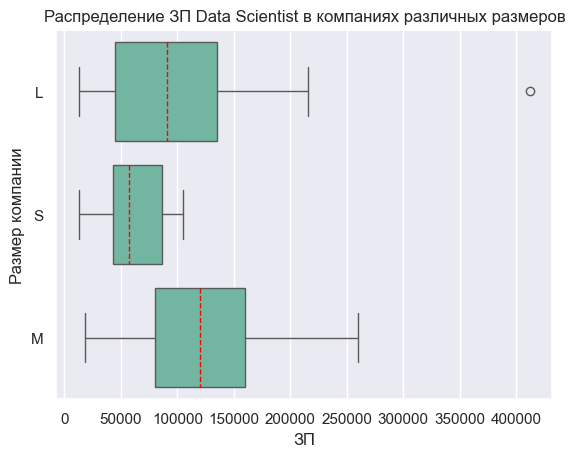

In [30]:
mask = data['job_title'] == 'Data Scientist'
filtered = data[mask]

ax = sns.boxplot(filtered, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='ЗП', ylabel='Размер компании')
plt.title('Распределение ЗП Data Scientist в компаниях различных размеров')
plt.show()

In [31]:
data_agg = filtered.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение ЗП Data Scientist в компаниях различных размеров')
data_agg

Распределение ЗП Data Scientist в компаниях различных размеров


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,43.0,102743.42,73254.10,13400.0,45240.50,90734.0,135000.0,412000.0
M,65.0,121866.43,54871.69,18442.0,80000.00,120000.0,160000.0,260000.0
S,18.0,59579.83,29368.62,12901.0,43087.75,57023.5,86428.5,105000.0


**ВЫВОД**: В средних компаниях уровень ЗП наибольший.
Наименьший уровень ЗП в небольших компаниях

**Проверяем есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании**

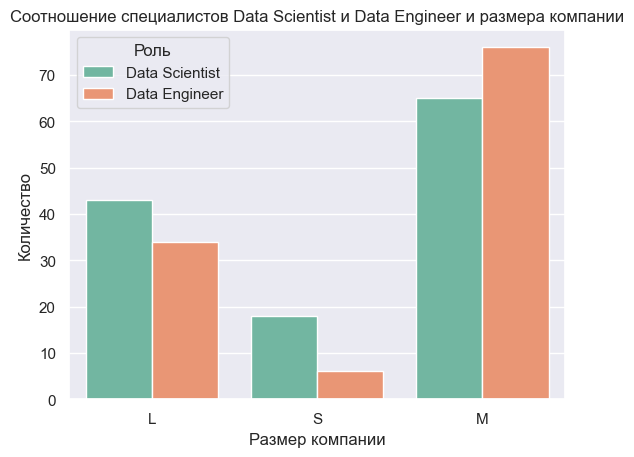

In [32]:
ax = sns.countplot(data=data, x=data['company_size'], hue='job_title')
ax.set(xlabel='Размер компании', ylabel='Количество')
ax.legend(title="Роль")
plt.title('Соотношение специалистов Data Scientist и Data Engineer и размера компании')
plt.show()

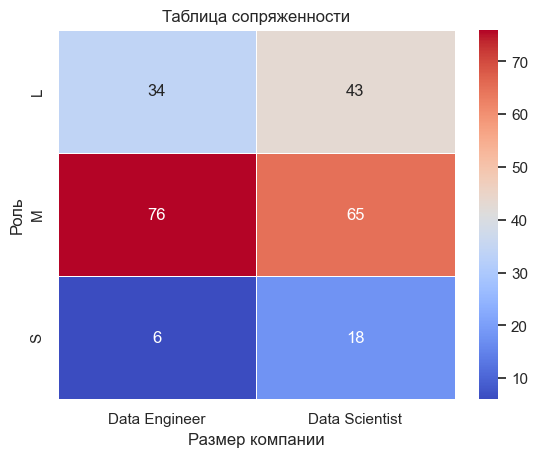

In [33]:
cross_tab = pd.crosstab(index=data['company_size'], columns=data['job_title'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Роль')
plt.title('Таблица сопряженности')
plt.show()

**ВЫВОД**: 
1) Количество специалистов с ролью Data Scientist в малых компаниях почти в три раза привышает количество специалистов с ролью Data Engineer
2) Незначительное, но также больше Data Scientist специалистов в круаных компаниях
3) В средних компаниях мы видем обратную ситуацию, специалистов с ролью  Data Engineer незначительно но больше специалистов с ролью Data Scientist.
4) Судя по таблице сопряженности, явных зависимостей размера компании и роли не наблюдается

## 2.2. Статистический анализ данных

### 2.2.1. Нулевые и альтернативные гипотезы

**БИЗНЕС-ВОПРОС: Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**

Нулевая гипотеза: (зп в 2020 г. >= зп в 2021 г.) и (зп в 2021 г. >= зп в 2022 г.)

Альтернативная гипотеза: (зп в 2020 г. < зп в 2021 г.) и (зп в 2021 г. < зп в 2022 г.)

Для выбора теста иследуем выборки:

In [34]:
# Проверить количество записей в каждой выборке
# 2020 г.
mask = data['job_title'] == 'Data Scientist'
mask_year = data['work_year']== 2020
data_2020 = data[mask & mask_year]
data_2020.shape[0]

21

In [35]:
# 2021 г.
mask = data['job_title'] == 'Data Scientist'
mask_year = data['work_year']== 2021
data_2021 = data[mask & mask_year]
data_2021.shape[0]

40

In [36]:
# 2022 г.
mask = data['job_title'] == 'Data Scientist'
mask_year = data['work_year']== 2022
data_2022 = data[mask & mask_year]
data_2022.shape[0]

65

т.к. в 2020 году выборка имеет сравнительно небольшое количество записей, то мы можем не брать в расчет 2020 год и переформулировать гипотезы:

Нулевая гипотеза: зп в 2021 г. >= зп в 2022 г.

Альтернативная гипотеза: зп в 2021 г. < зп в 2022 г.

Дополняем выборку data_2021 25 записями со средним значением

In [37]:
# значения зп в 2021 и 2022 гг.
data_ds = data[data['job_title']=='Data Scientist']
salary_2021 = data_ds.loc[data_ds['work_year']==2021, 'salary_in_usd']
salary_2022 = data_ds.loc[data_ds['work_year']==2022, 'salary_in_usd']

mean_values = salary_2021.mean()
new_values = [mean_values] * 25
salary_2021 = pd.concat([salary_2021, pd.Series(new_values)])


С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально

In [38]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

In [39]:
# проводим тест Шапиро-Уилка
print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

Для 2021:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США за соответствующий год»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет

Выбираем тест **МАННА — УИТНИ**

In [40]:
# задаём уровень значимости
alpha = 0.05 


# проводим тест
_, p = stats.mannwhitneyu(salary_2021, salary_2022)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**БИЗНЕС-ВОПРОС: Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?**

Нулевая гипотеза: зп Data Scientist в 2022 г. == зп Data Engineer в 2022 г.

Альтернативная гипотеза: зп Data Scientist в 2022 г. != зп Data Engineer в 2022 г.

Для выбора теста иследуем выборки:

In [41]:
# Проверить количество записей в каждой выборке
mask_job = data['job_title'] == 'Data Scientist'
mask_year = data['work_year']== 2022
data_2022_ds = data[mask_job & mask_year]
data_2022_ds.shape[0]

65

In [42]:
mask_job = data['job_title'] == 'Data Engineer'
mask_year = data['work_year']== 2022
data_2022_de = data[mask_job & mask_year]
data_2022_de.shape[0]

75

Дополняем выборку data_2021 10 записями со средним значением

In [43]:
# значения зп DS и DE в 2022 гг.
data_2022 = data[data['work_year']==2022]
salary_ds = data_2022.loc[data_2022['job_title']=='Data Scientist', 'salary_in_usd']
salary_de = data_2022.loc[data_2022['job_title']=='Data Engineer', 'salary_in_usd']

mean_values = salary_ds.mean()
new_values = [mean_values] * 10
salary_ds = pd.concat([salary_ds, pd.Series(new_values)])


С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально

In [44]:
# проводим тест Шапиро-Уилка
print('Для 2021:')
result = stats.shapiro(salary_ds)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_de)
decision_normality(result[1])

Для 2021:
p-value = 0.433
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.022
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США за 2022 г»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет

Выбираем тест **МАННА — УИТНИ**

In [45]:
# задаём уровень значимости
alpha = 0.05 


# проводим тест
_, p = stats.mannwhitneyu(salary_de, salary_ds)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.466
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**БИЗНЕС-ВОПРОС: Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**

Нулевая гипотеза: зп Data Scientist в компаниях различных размеров одинаковые

Альтернативная гипотеза: зп Data Scientist в компаниях различных размеров не одинаковые

Для выбора теста иследуем выборки:

In [46]:
# Проверить количество записей в каждой выборке
# S — менее 50 сотрудников (небольшая компания)
mask_job = data['job_title'] == 'Data Scientist'
mask_company_size = data['company_size']== 'S'
data_ds_s = data[mask_job & mask_company_size]
data_ds_s.shape[0]

18

In [47]:
# M — от 50 до 250 сотрудников (средняя компания);
mask_company_size = data['company_size']== 'M'
data_ds_m = data[mask_job & mask_company_size]
data_ds_m.shape[0]

65

In [48]:
# L — более 250 сотрудников (крупная компания).
mask_company_size = data['company_size']== 'L'
data_ds_l = data[mask_job & mask_company_size]
data_ds_l.shape[0]

43

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально

In [49]:
# значения зп DS в зависимсоти от размера компании.
data_ds = data[data['job_title']=='Data Scientist']
salary_ds_s = data_ds.loc[data_ds['company_size']=='S', 'salary_in_usd']
salary_ds_m = data_ds.loc[data_ds['company_size']=='M', 'salary_in_usd']
salary_ds_l = data_ds.loc[data_ds['company_size']=='L', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_ds_s)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_ds_m)
decision_normality(result[1])

print('Для L:')
result = stats.shapiro(salary_ds_l)
decision_normality(result[1])

Для S:
p-value = 0.361
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.666
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет (распределение в выборке зп DS L компаний отлично от нормального).

Выбираем **КРИТЕРИЙ КРАСКЕЛА — УОЛЛИСА**

In [50]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест
_, p = stats.kruskal(salary_ds_s, salary_ds_m, salary_ds_l)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Иследуем попарно зп в разных по размерам компаниях**

**Рассмотрим зп в S-компаниях и M-компаниях**

Сформулируем новую гипотезу:

Нулевая гипотеза: зп Data Scientist в S-компаниях >= зп Data Scientist в M-компаниях

Альтернативная гипотеза: зп Data Scientist в S-компаниях < зп Data Scientist в M-компаниях

Иследуем выборки

In [51]:
print(f"количество записей в S {salary_ds_s.shape[0]}") 
print(f"количество записей в M {salary_ds_m.shape[0]}") 
print(f"количество записей в L {salary_ds_l.shape[0]}") 

количество записей в S 18
количество записей в M 65
количество записей в L 43


Дополняем выборки

In [52]:
mean_values = salary_ds_s.mean()
new_values = [mean_values] * 47
salary_ds_s = pd.concat([salary_ds_s, pd.Series(new_values)])


mean_values = salary_ds_l.mean()
new_values = [mean_values] * 22
salary_ds_l = pd.concat([salary_ds_l, pd.Series(new_values)])

In [53]:
# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_ds_s)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_ds_m)
decision_normality(result[1])

print('Для L:')
result = stats.shapiro(salary_ds_l)
decision_normality(result[1])

Для S:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для M:
p-value = 0.666
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. (распределение в выборке зп DS L компаний отлично от нормального).

Выбираем тест **МАННА — УИТНИ**

In [54]:
# задаём уровень значимости
alpha = 0.05 


# проводим тест
_, p = stats.mannwhitneyu(salary_ds_m, salary_ds_s)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Рассмотрим зп в L-компаниях и M-компаниях**

Сформулируем новую гипотезу:

Нулевая гипотеза: зп Data Scientist в L-компаниях >= зп Data Scientist в M-компаниях

Альтернативная гипотеза: зп Data Scientist в L-компаниях < зп Data Scientist в M-компаниях

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. (распределение в выборке зп DS L компаний отлично от нормального).

Выбираем тест **МАННА — УИТНИ**

In [55]:
# задаём уровень значимости
alpha = 0.05 


# проводим тест
_, p = stats.mannwhitneyu(salary_ds_m, salary_ds_l)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.031
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Рассмотрим зп в S-компаниях и L-компаниях**

Сформулируем новую гипотезу:

Нулевая гипотеза: зп Data Scientist в S-компаниях >= зп Data Scientist в L-компаниях

Альтернативная гипотеза: зп Data Scientist в S-компаниях < зп Data Scientist в L-компаниях

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. (распределение в выборке зп DS L компаний отлично от нормального).

Выбираем тест **МАННА — УИТНИ**

In [56]:
# задаём уровень значимости
alpha = 0.05 


# проводим тест
_, p = stats.mannwhitneyu(salary_ds_l, salary_ds_s)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**БИЗНЕС-ВОПРОС: Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?**

Нулевая гипотеза: признаки «Размером компании» и «Наличием должностей Data Scientist и Data Engineer» независимы.

Альтернативная гипотеза: признаки «Размером компании» и «Наличием должностей Data Scientist и Data Engineer» взаимосвязаны.

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Что сравниваем? - Категориальные признаки в части их связанности
* Какой тип у сравниваемых признаков «Размером компании» и «Наличием должностей Data Scientist и Data Engineer»? — Категориальные.
* Количество сравниваемых категориальных признака? — Два.

Выбираем тест **КРИТЕРИЙ ХИ-КВАДРАТ**

In [57]:
# задаём уровень значимости
alpha = 0.05 


# вычисляем таблицу сопряжённости
table = pd.crosstab(data['company_size'], data['job_title'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


---
# 3. **Выводы по бизнес-вопросам**

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Да, наблюдается ежегодный рост зарплат у специалистов Data Scientist**

- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Тесты показали, что уравень зарплаты Data Scientist и Data Engineer в 2022 году относительно одинаковый.** Однако, на диаграмме видим, что средний уровень зп DS немного выше уровня зп DE.

- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Уровень зп специалистов Data Scientist в компаниях различных размеров различается.** В средних компаниях уровень зп выше, чем в крупных и небольших компаниях. В тоже время уровень зп в крупных компаниях выше, чем уровень зп в небольших компаниях.

- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Да, есть связь между наличием должностей Data Scientist и Data Engineer и размером компании.** На основе диаграммы можем сделать вывод, что в компаниях среднего размера DE больше чем DS, а в крупных и небольших компаниях DS больше чем DE


---
# 4. **Дополнительное исследование**

## 4.1 Иследуем, есть ли зависимость зп DS от опыта работы в 2022 г.

Иследуем выборки

In [58]:
mask1 = data['job_title']=='Data Scientist'
mask2 = data['work_year']==2022
data_ds_2022 = data[mask1 & mask2]
salary_ds_2022_en = data_ds_2022.loc[data_ds_2022['experience_level']=='EN', 'salary_in_usd']
salary_ds_2022_mi = data_ds_2022.loc[data_ds_2022['experience_level']=='MI', 'salary_in_usd']
salary_ds_2022_se = data_ds_2022.loc[data_ds_2022['experience_level']=='SE', 'salary_in_usd']
salary_ds_2022_ex = data_ds_2022.loc[data_ds_2022['experience_level']=='EX', 'salary_in_usd']


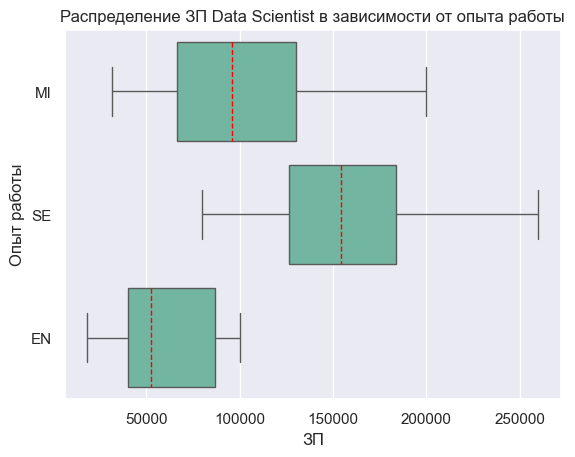

In [59]:
ax = sns.boxplot(data_ds_2022, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='ЗП', ylabel='Опыт работы')
plt.title('Распределение ЗП Data Scientist в зависимости от опыта работы')
plt.show()

In [60]:
print(f"Количество специалистов с опытом работы EN: {salary_ds_2022_en.shape[0]}")
print(f"Количество специалистов с опытом работы MI: {salary_ds_2022_mi.shape[0]}")
print(f"Количество специалистов с опытом работы SE: {salary_ds_2022_se.shape[0]}")
print(f"Количество специалистов с опытом работы EX: {salary_ds_2022_ex.shape[0]}")

Количество специалистов с опытом работы EN: 5
Количество специалистов с опытом работы MI: 22
Количество специалистов с опытом работы SE: 38
Количество специалистов с опытом работы EX: 0


Дополняем выборку salary_ds_2022_mi 16 записями со средним значением

In [61]:
mean_values = salary_ds_2022_mi.mean()
new_values = [mean_values] * 16
salary_ds_2022_mi = pd.concat([salary_ds_2022_mi, pd.Series(new_values)])
salary_ds_2022_mi = salary_ds_2022_mi.sort_values()

Из-за отсутствия значений или значительно меньшего количество записей выборки мы не рассматриваем опыт работы EN и EX

**Сформулируем гипотезу:**

Нулевая гипотеза: зп Data Scientist с опытом работы MI — Mid-level/Intermediate >= зп Data Scientist с опытом работы SE — Senior-level/Expert;

Альтернативная гипотеза: зп Data Scientist с опытом работы MI — Mid-level/Intermediate < зп Data Scientist с опытом работы SE — Senior-level/Expert;

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально

In [62]:
# проводим тест Шапиро-Уилка
print('Для MI:')
result = stats.shapiro(salary_ds_2022_mi)
decision_normality(result[1])

print('Для SE:')
result = stats.shapiro(salary_ds_2022_se)
decision_normality(result[1])

Для MI:
p-value = 0.003
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для SE:
p-value = 0.602
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Выбираем тест **МАННА — УИТНИ**

In [63]:
# задаём уровень значимости
alpha = 0.05 


# проводим тест
_, p = stats.mannwhitneyu(salary_ds_2022_se, salary_ds_2022_mi)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


## 4.2 Иследуем, есть ли зависимость зп DS от объема работ, выполняемой удаленно в 2022 г.

In [64]:
mask1 = data['job_title']=='Data Scientist'
mask2 = data['work_year']==2022
data_ds_2022 = data[mask1 & mask2]
salary_ds_2022_0 = data_ds_2022.loc[data_ds_2022['remote_ratio']==0, 'salary_in_usd']
salary_ds_2022_50 = data_ds_2022.loc[data_ds_2022['remote_ratio']==50, 'salary_in_usd']
salary_ds_2022_100 = data_ds_2022.loc[data_ds_2022['remote_ratio']==100, 'salary_in_usd']

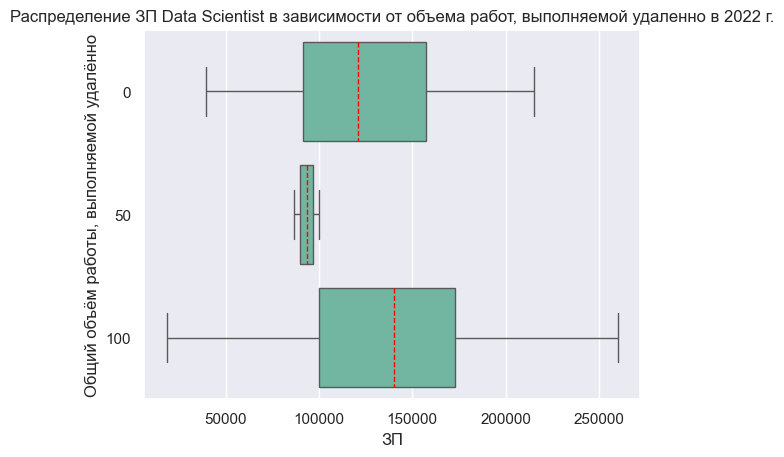

In [65]:
ax = sns.boxplot(data_ds_2022, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='ЗП', ylabel='Общий объём работы, выполняемой удалённо')
plt.title('Распределение ЗП Data Scientist в зависимости от объема работ, выполняемой удаленно в 2022 г.')
plt.show()

In [66]:
print(f"удалённой работы нет : {salary_ds_2022_0.shape[0]}")
print(f"частично удалённая работа: {salary_ds_2022_50.shape[0]}")
print(f"полностью удалённая работа: {salary_ds_2022_100.shape[0]}")

удалённой работы нет : 24
частично удалённая работа: 2
полностью удалённая работа: 39


Дополняем выборку salary_ds_2022_0 15-ю записями со средним значением

In [67]:
mean_values = salary_ds_2022_0.mean()
new_values = [mean_values] * 15
salary_ds_2022_0 = pd.concat([salary_ds_2022_0, pd.Series(new_values)])

Из-за значительно меньшего количество записей выборки мы не рассматриваем частично удаленную работу

Сформулируем гипотезу:

Нулевая гипотеза: зп Data Scientist при удаленной работе >= зп Data Scientist при работе в офисе;

Альтернативная гипотеза: зп Data Scientist при удаленной работе < зп Data Scientist при работе в офисе;

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально

In [68]:
# проводим тест Шапиро-Уилка
print('Для MI:')
result = stats.shapiro(salary_ds_2022_0)
decision_normality(result[1])

print('Для SE:')
result = stats.shapiro(salary_ds_2022_100)
decision_normality(result[1])

Для MI:
p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для SE:
p-value = 0.578
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Выбираем тест **МАННА — УИТНИ**

In [69]:
# задаём уровень значимости
alpha = 0.05 


# проводим тест
_, p = stats.mannwhitneyu(salary_ds_2022_100, salary_ds_2022_0)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## 4.3 Иследуем, есть ли связь между объёмом работы, выполняемой удалённо и размером компании

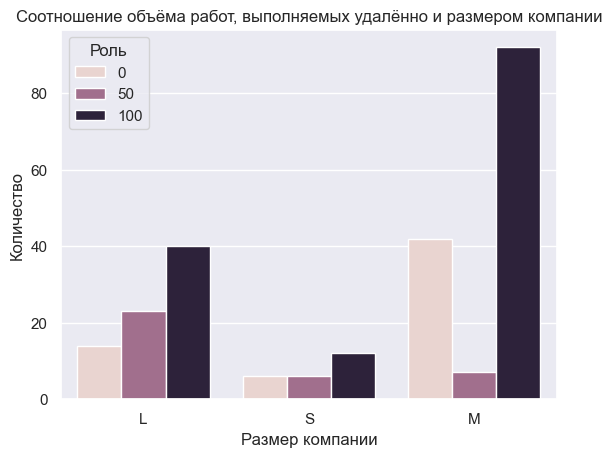

In [70]:
ax = sns.countplot(data=data, x=data['company_size'], hue='remote_ratio')
ax.set(xlabel='Размер компании', ylabel='Количество')
ax.legend(title="Роль")
plt.title('Соотношение объёма работ, выполняемых удалённо и размером компании')
plt.show()

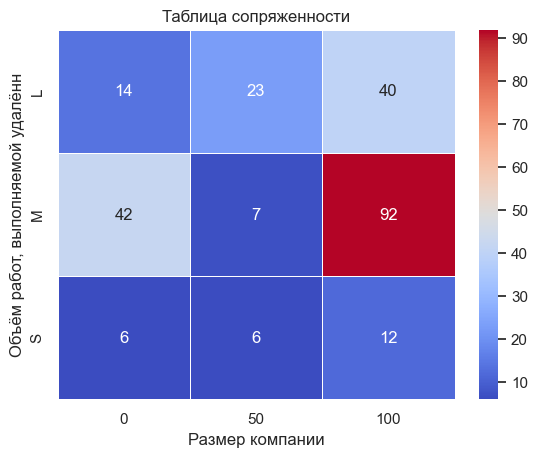

In [71]:
cross_tab = pd.crosstab(index=data['company_size'], columns=data['remote_ratio'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Объём работ, выполняемой удалённ')
plt.title('Таблица сопряженности')
plt.show()

Нулевая гипотеза: признаки «Размером компании» и «Объём работы, выполняемой удалённо» независимы.

Альтернативная гипотеза: признаки «Размером компании» и «Объём работы, выполняемой удалённо» взаимосвязаны.

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Что сравниваем? - Категориальные признаки в части их связанности
* Какой тип у сравниваемых признаков «Размером компании» и «Наличием должностей Data Scientist и Data Engineer»? — Категориальные.
* Количество сравниваемых категориальных признака? — Два.

Выбираем тест **КРИТЕРИЙ ХИ-КВАДРАТ**

In [72]:
# задаём уровень значимости
alpha = 0.05 


# вычисляем таблицу сопряжённости
table = pd.crosstab(data['company_size'], data['remote_ratio'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


## 4.4 Растет ли объем работ, выполняемых удаленно с каждым годом в компаниях среднего размера

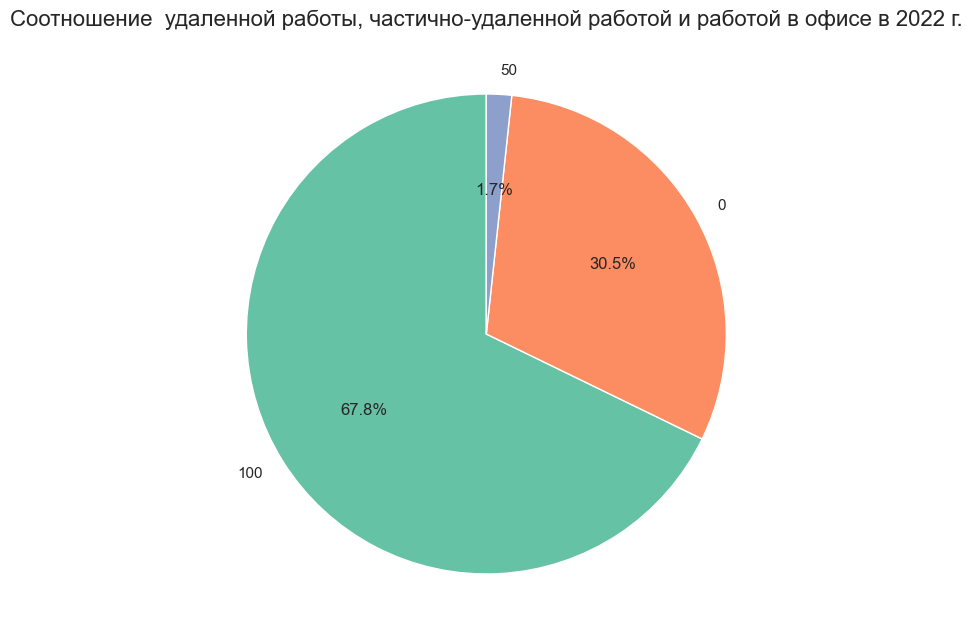

In [73]:
mask1 = data['company_size'] == 'M'
mask2 = data['work_year'] == 2022
filtered = data[mask1 & mask2]


fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((1, 1, 1, 1))
remote_ration_count = filtered['remote_ratio'].value_counts().sort_values(ascending=False)
pie = ax.pie(
    remote_ration_count,
    labels=remote_ration_count.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Соотношение  удаленной работы, частично-удаленной работой и работой в офисе в 2022 г.', fontsize=16)
plt.show(pie)


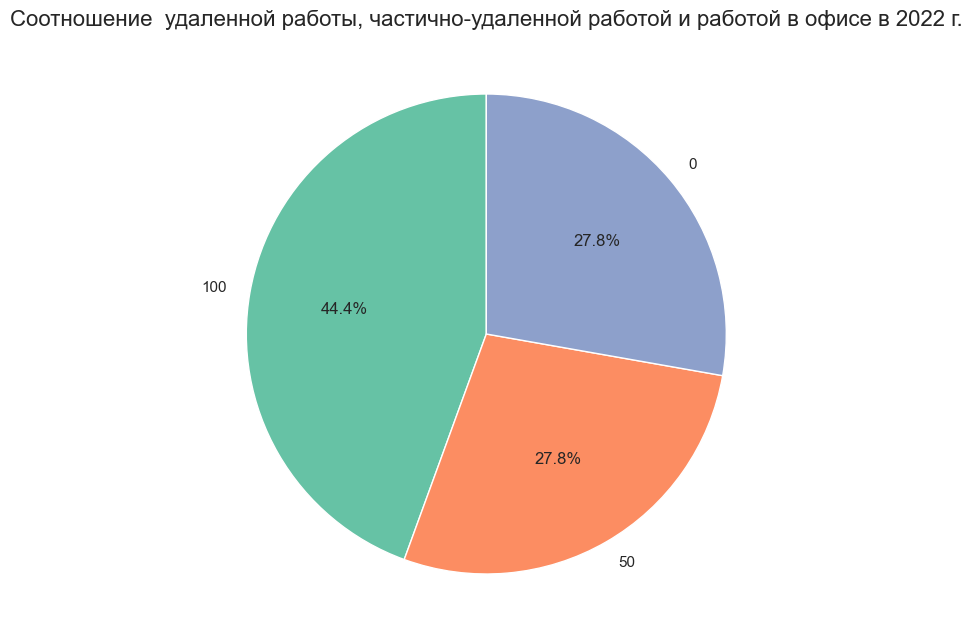

In [74]:
mask1 = data['company_size'] == 'M'
mask2 = data['work_year'] == 2021
filtered = data[mask1 & mask2]


fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((1, 1, 1, 1))
remote_ration_count = filtered['remote_ratio'].value_counts().sort_values(ascending=False)
pie = ax.pie(
    remote_ration_count,
    labels=remote_ration_count.index,
    autopct='%1.1f%%',
    startangle=90
)
title = ax.set_title('Соотношение  удаленной работы, частично-удаленной работой и работой в офисе в 2022 г.', fontsize=16)
plt.show(pie)

## 4.5 Выводы по дополнительным иследованиям

1) Как и следовало ожидать, есть зависимость зп DS от опыта работы. Чем больше опыт работы, тем более высокая зп
2) Также иследования показали, что зп выше у DS, которые работают в офисе
3) Иследуя зависимсоть между объемом работ выполняемых удаленно и размером компании, мы видим, что чем больше компания, тем больше работ выполняется удаленно. Также наблюдаем рост процента выполняемой удаленно работы в 2022 году по сравнению с 2021 годом

---
# **ФИНАЛЬНЫЕ ВЫВОДЫ**

Обобщив все выводы, можно сказать, что зп специалистов DS растет с каждым годом. Также видим, что с каждым годом ростет процент работы, которая полностью выполняется удаленно.
Наиболее высокий уровень зп DS мы наблюдаем в средних компаниях. 
С ростом компании, увеличивается потребность в специалистах с ролью DE, это скорее всего связано с тем, что растет объем обрабатываемых данных и усложняется их структура.
Однако, иследования показали, что зп специалистов с ролью DE значимо не отличается от зп специалиста с ролью DS.